In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
from torchsummary import summary
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
from PIL import Image

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder('/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/xAI/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)


In [6]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)

        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [7]:
# initialize the VGG model
vgg = VGG()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
vgg.vgg


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [9]:
for param in vgg.vgg.parameters():
    param.requires_grad = False

In [10]:
vgg.vgg.classifier[6] = nn.Linear(4096, 2)
# vgg.vgg.classifier.add_module("7", nn.LogSoftmax(dim = 1))
vgg.vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [11]:
summary(vgg.vgg, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [12]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.vgg.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [14]:
def load_images_and_labels(folder_path):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):

            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.convert("RGB")

            image = image.resize((224,224))
            image_array = np.array(image) / 255.0
            # images.append(image_array)

            if ("target" in filename) & ("nontarget" not in filename):
                images.append(image_array)
                labels.append(1)
            elif "nontarget" in filename:
                images.append(image_array)
                labels.append(0)
            else:
                # print(filename)
                # raise ValueError("Invalid filename format")

    return np.array(images), np.array(labels)

In [15]:
folder_path = '/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/Scalograms/'
X, Y = load_images_and_labels(folder_path)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

01_trial_01__1.png
01_trial_02__-1.png
01_trial_03__-1.png
01_trial_00__-1.png
01_trial_04__-1.png
01_trial_05__-1.png
01_trial_06__-1.png
01_trial_07__-1.png
01_trial_08__-1.png
01_trial_09__1.png
01_trial_10__-1.png
01_trial_11__-1.png
01_trial_12__-1.png
01_trial_13__-1.png
01_trial_14__-1.png
01_trial_15__-1.png
01_trial_16__-1.png
01_trial_17__1.png
01_trial_18__1.png
01_trial_19__-1.png
01_trial_20__-1.png
01_trial_21__-1.png
01_trial_22__-1.png
01_trial_23__-1.png
01_trial_24__-1.png
01_trial_25__-1.png
01_trial_26__-1.png
01_trial_27__-1.png
01_trial_28__-1.png
01_trial_29__-1.png
01_trial_30__-1.png
01_trial_31__-1.png
01_trial_32__-1.png
01_trial_33__-1.png
01_trial_34__-1.png
01_trial_35__-1.png
01_trial_36__-1.png
01_trial_38__1.png
01_trial_39__1.png
01_trial_40__-1.png
01_trial_41__-1.png
01_trial_42__1.png
01_trial_43__-1.png
01_trial_44__-1.png
01_trial_45__-1.png
01_trial_46__-1.png
01_trial_47__-1.png
01_trial_48__1.png
01_trial_49__-1.png
01_trial_50__-1.png
01_trial

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images here i used imagenet stats
])


In [17]:
# Create dataset
dataset = CustomDataset(X, Y, transform=transform)

# Define data loader
batch_size = 16

# Split the dataset into training and testing subsets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
len(dataset)

256

In [44]:
test_dataset[0][1]

0

In [18]:
num_epochs = 1
for epoch in range(num_epochs):
    # Training loop
    vgg.vgg.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = vgg.vgg(images.float())
        # print(outputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    vgg.vgg.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for images, labels in test_loader:
            outputs = vgg.vgg(images.float())
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
        accuracy = total_correct / total_samples
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}')




Epoch [1/1], Accuracy: 1.0000


# **Nontarget**

In [46]:
# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

In [48]:
img.requires_grad_(True)

tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2

In [49]:
vgg(img)

tensor([[ 0.7622, -1.4844]], grad_fn=<AddmmBackward0>)

In [50]:
# get the most likely prediction of the model
pred_class = vgg(img).argmax(dim=1).numpy()[0]
pred = vgg(img)


In [51]:
pred[:, pred_class].backward()

In [52]:
# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

In [54]:
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()


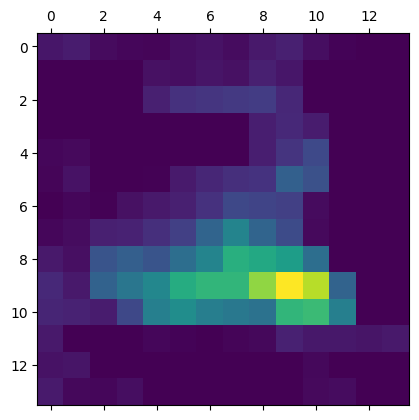

In [55]:
# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [56]:
import cv2
img = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/xAI/0/03_trial_51__nontarget.png')

heatmap = cv2.resize(np.array(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
# cv2.imwrite('/content/gdrive/MyDrive/Colab Notebooks/Explainability/Dataset/Elephant/map.jpg', superimposed_img)

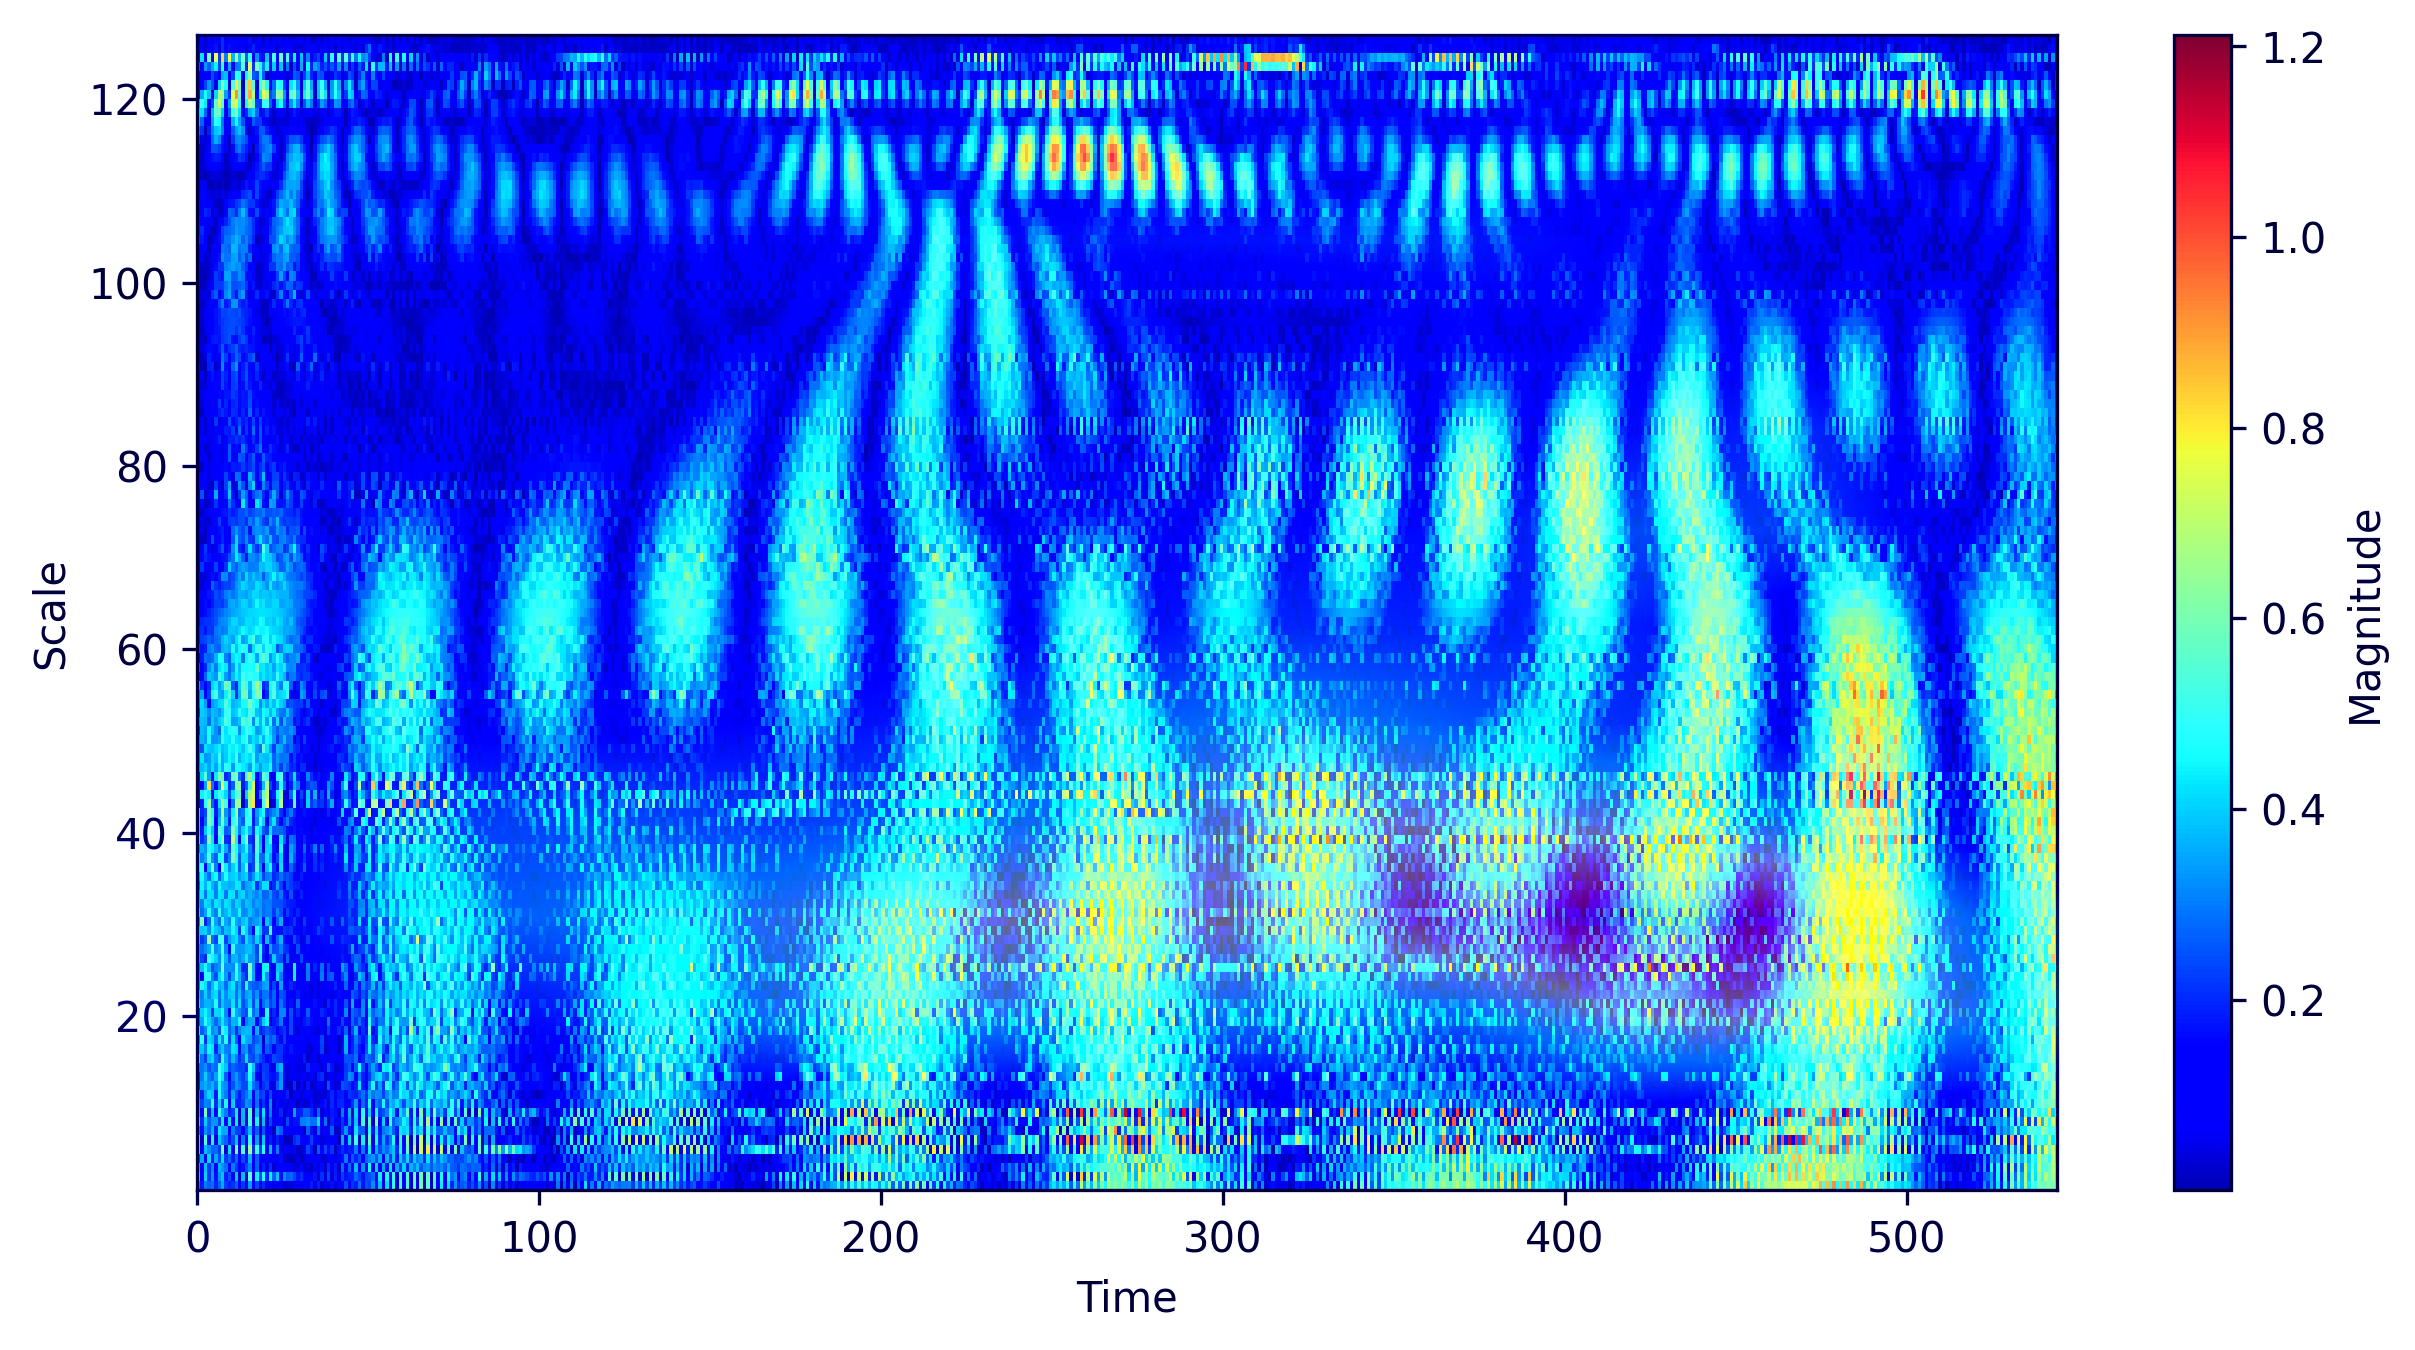

In [57]:
from google.colab.patches import cv2_imshow
cv2_imshow(superimposed_img)

# **Target**

In [25]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder('/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/XAI_p300_target/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)


In [26]:
# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

In [27]:
img.requires_grad_(True)

tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2

In [22]:
vgg(img)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1612800 and 25088x4096)

In [28]:
# get the most likely prediction of the model
pred_class = vgg(img).argmax(dim=1).numpy()[0]
pred = vgg(img)


In [29]:
pred[:, pred_class].backward()

In [30]:
# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

In [31]:
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()


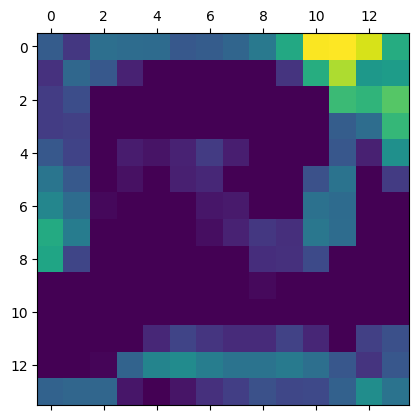

In [32]:
# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [33]:
import cv2
img = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/xAI/0/03_trial_51__nontarget.png')

heatmap = cv2.resize(np.array(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
# cv2.imwrite('/content/gdrive/MyDrive/Colab Notebooks/Explainability/Dataset/Elephant/map.jpg', superimposed_img)

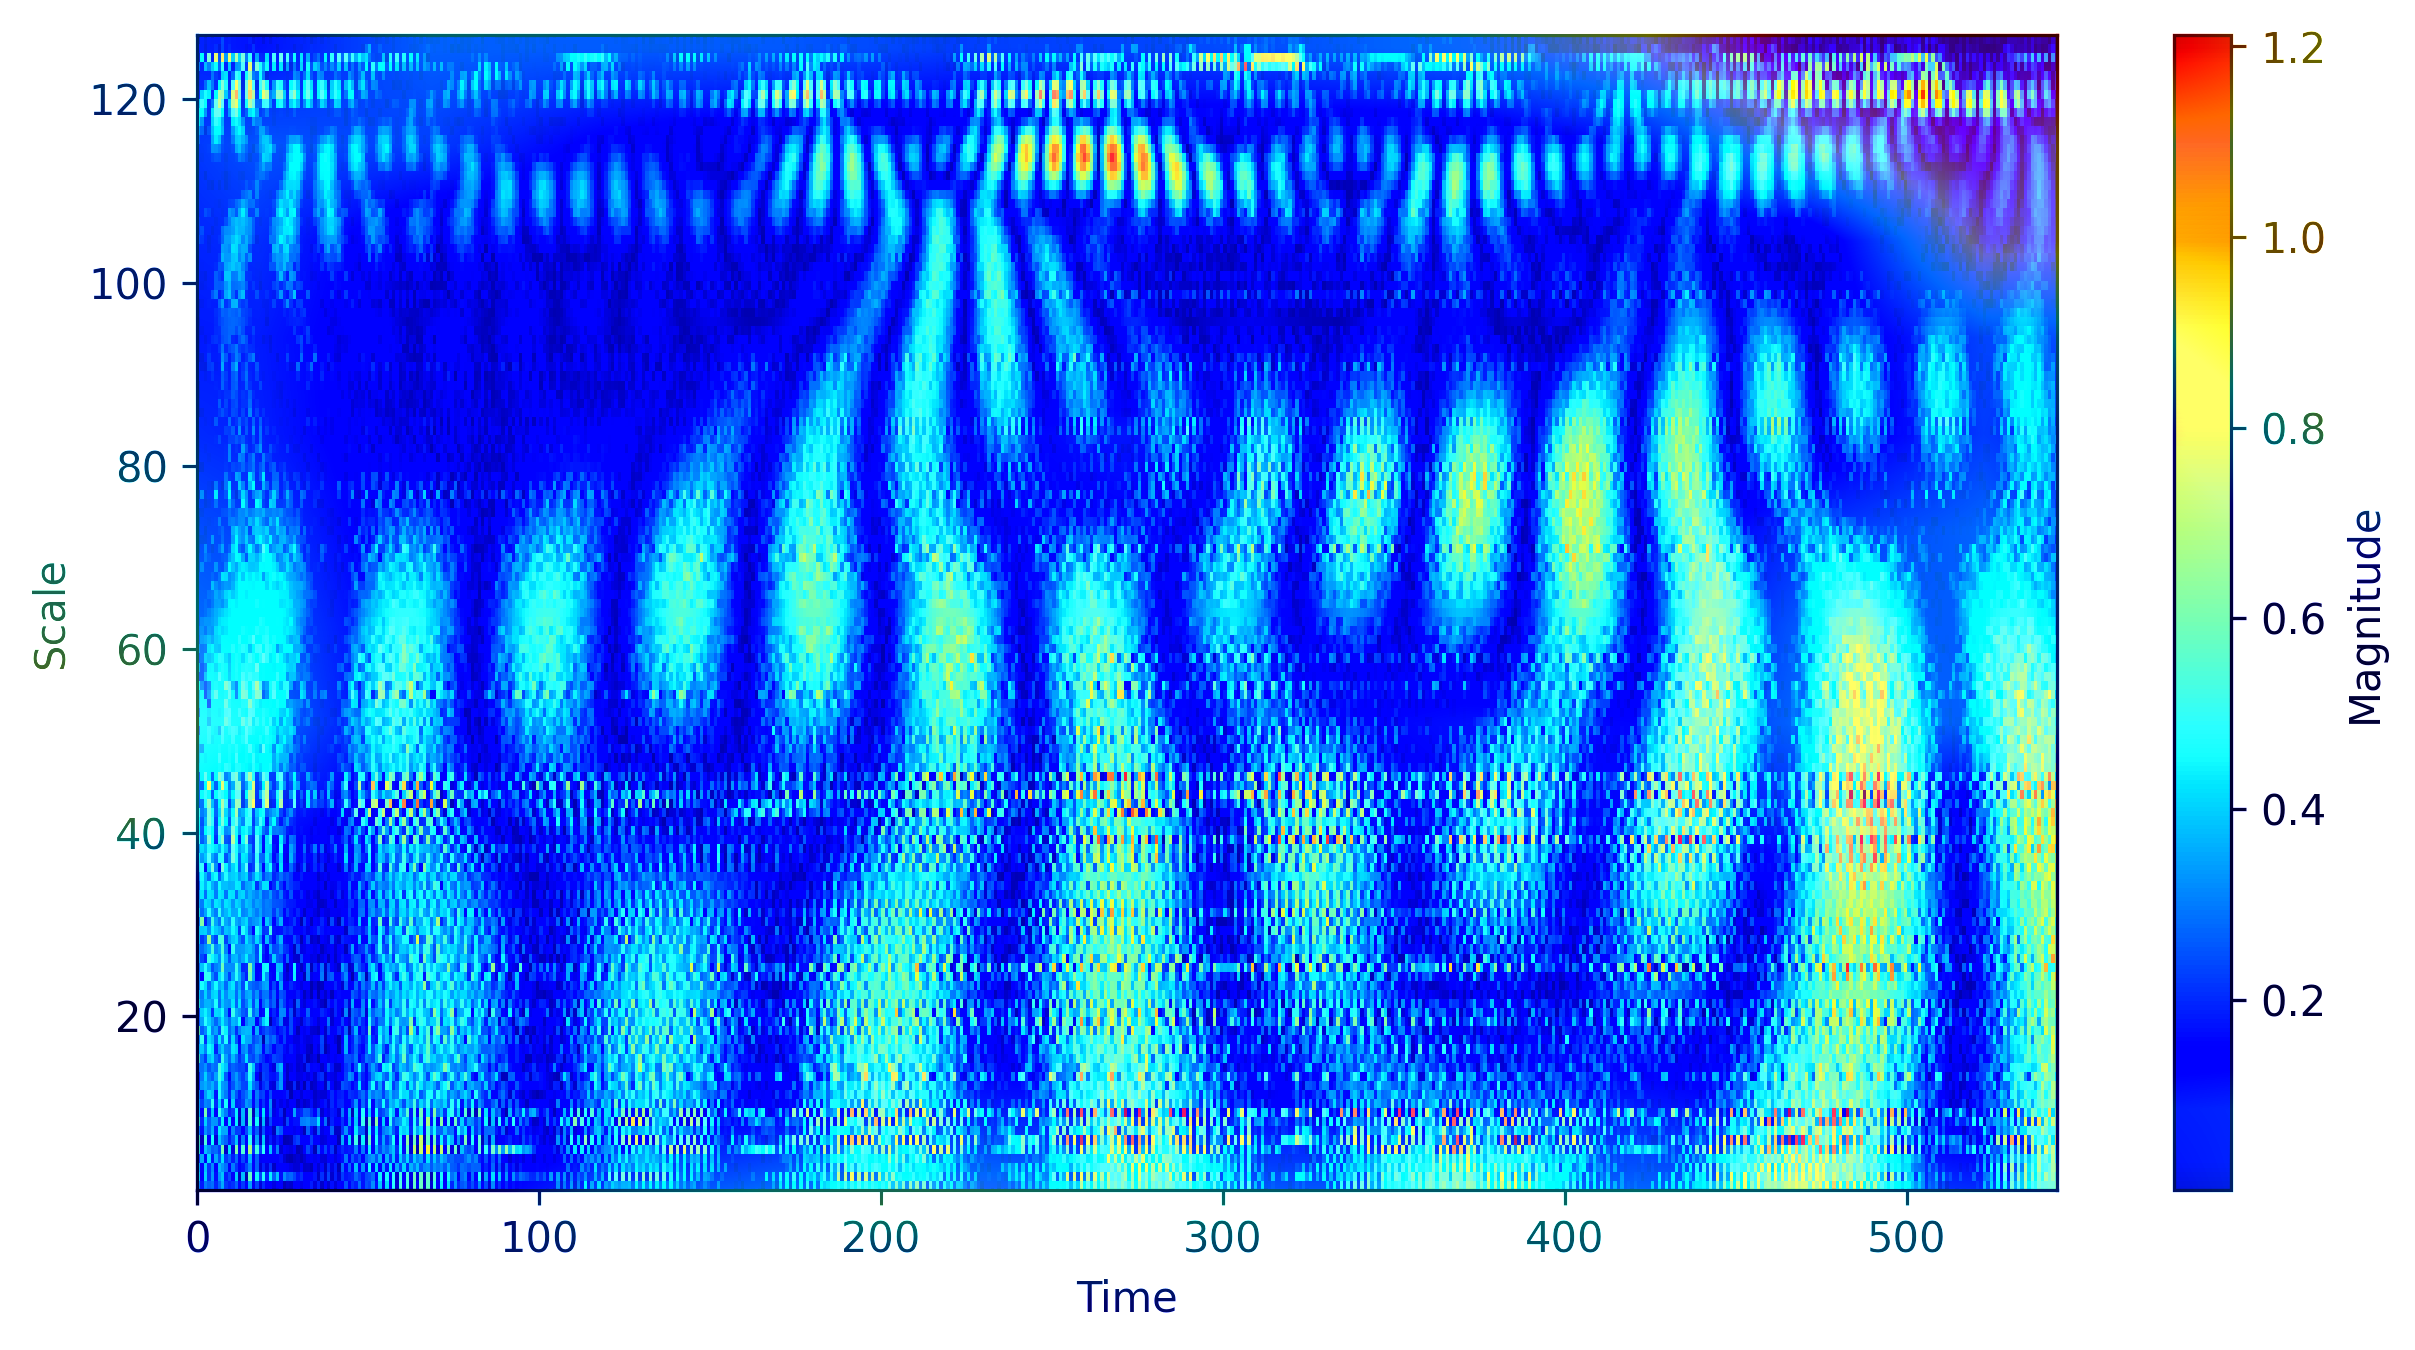

In [34]:
from google.colab.patches import cv2_imshow
cv2_imshow(superimposed_img)

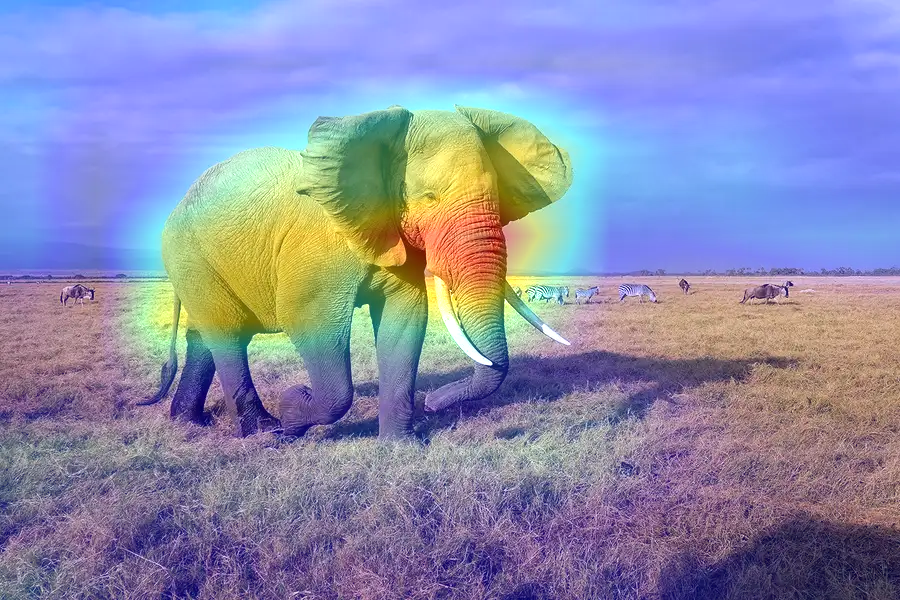

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(superimposed_img)